In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install stif[geo]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
import sklearn.metrics

import scipy.stats

import tqdm.notebook as tqdm

from stif import Data
from stif import Predictor
import stif

First, we load the data. Data up to 2003 is stored yearly. After that, it is stored in a single file called `Wetter_rest.csv` Time is is days, x and y are in meters.

In [ ]:
years = [str(a) for a in range(1992, 2003)] + ["rest"]

In [ ]:
df = pd.DataFrame()
for year in years:
    year_df = pd.read_csv(
        f"/content/drive/MyDrive/frost/Wetter_{year}.csv", index_col=0)
    df = pd.concat([df, year_df])

In [ ]:
df.columns

Index(['Station_ID', 'YEARMODA', 'Year', 'Month', 'Day', 'Wind_speed',
       'Wind_speed_max', 'ATM_pressure', 'Rainfall', 'Snow', 'Tmin_5cm',
       'Tmean', 'Tmin', 'Tmax', 'RH', 'VPD', 'JDay', 'Stationsname', 'Kennung',
       'Stationskennung', 'Breite', 'Laenge', 'Stationshoehe', 'Flussgebiet',
       'Bundesland', 'Beginn', 'Ende'],
      dtype='object')

In [ ]:
df.rename(columns={"Stationshoehe": "Stationshöhe", "Laenge": "Länge"}, inplace=True)

In [ ]:
df = df[['Year', 'Month', 'Day', 'Tmean', 'Tmin', 'Tmax', 'Breite', 'Länge', 'Stationshöhe', 'Stationskennung']]

In [ ]:
df.dropna(inplace=True)

In [ ]:
df

,Year,Month,Day,Tmean,Tmin,Tmax,Breite,Länge,Stationshöhe,Stationskennung
367,1992,1,1,6.2,2.9,7.8,52.934,8.237,44,1510
368,1992,1,2,7.1,6.8,7.8,52.934,8.237,44,1510
369,1992,1,3,5.1,4.1,7.3,52.934,8.237,44,1510
370,1992,1,4,6.1,4.5,8.0,52.934,8.237,44,1510
371,1992,1,5,4.3,3.8,5.6,52.934,8.237,44,1510
...,...,...,...,...,...,...,...,...,...,...
249974,1992,12,27,-3.4,-7.6,0.7,49.455,8.979,178,8970
249975,1992,12,28,-2.4,-3.9,0.7,49.455,8.979,178,8970
249976,1992,12,29,-4.8,-8.0,0.9,49.455,8.979,178,8970
249977,1992,12,30,-4.7,-9.3,2.7,49.455,8.979,178,8970


In [ ]:
df["date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

In [ ]:
start_day = pd.to_datetime('1993-01-01')

In [ ]:
df["time"] = (df["date"] - start_day).dt.days

In [ ]:
location_coords = df.groupby('Stationskennung').agg({'Länge': 'first', 'Breite': 'first', 'Stationshöhe': 'first'}).reset_index()

In [ ]:
gdf = gpd.GeoDataFrame(location_coords, geometry=gpd.points_from_xy(location_coords['Länge'], location_coords['Breite']))

# Set EPSG to lan lon
gdf.set_crs(epsg=4326, inplace=True)

gdf

,Stationskennung,Länge,Breite,Stationshöhe,geometry
0,1040,7.8920,54.1750,4,POINT (7.892 54.175)
1,1060,7.4670,53.4620,4,POINT (7.467 53.462)
2,1061,7.1909,53.3449,5,POINT (7.1909 53.3449)
3,1065,7.8806,53.5322,7,POINT (7.8806 53.5322)
4,1070,7.6090,53.6480,3,POINT (7.609 53.648)
...,...,...,...,...,...
546,10739,9.2000,48.8281,321,POINT (9.2 48.8281)
547,10763,11.0549,49.5030,314,POINT (11.0549 49.503)
548,10866,11.7094,48.1369,529,POINT (11.7094 48.1369)
549,10921,8.9101,47.9760,793,POINT (8.9101 47.976)


<Axes: >

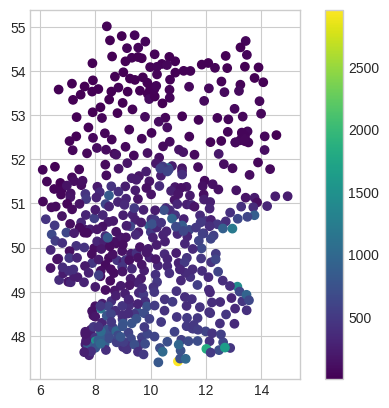

In [ ]:
gdf.plot(column="Stationshöhe", cmap="viridis", legend=True)

Let's add some elevation from 3rd party to compare (in the end we will need this 3rd party elevation for prediction anyways).

In [ ]:
dem_path = "https://userpage.fu-berlin.de/soga/data/raw-data/spatial/srtm_germany_dtm.zip"

# Download and unzip
!wget -O dem.zip $dem_path
!unzip -o dem.zip

--2025-03-17 17:08:20--  https://userpage.fu-berlin.de/soga/data/raw-data/spatial/srtm_germany_dtm.zip
Resolving userpage.fu-berlin.de (userpage.fu-berlin.de)... 130.133.4.196
Connecting to userpage.fu-berlin.de (userpage.fu-berlin.de)|130.133.4.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90583787 (86M) [application/zip]
Saving to: ‘dem.zip’

dem.zip             100%[===================>]  86.39M  26.6MB/s    in 4.4s    

2025-03-17 17:08:26 (19.5 MB/s) - ‘dem.zip’ saved [90583787/90583787]

Archive:  dem.zip
  inflating: srtm_germany_dtm.tif    


In [ ]:
# Read the GeoTIFF file
tiff_path = 'srtm_germany_dtm.tif'

with rasterio.open(tiff_path) as src:
    raster_crs = src.crs

    # Reproject the GeoDataFrame to match the raster's CRS
    gdf = gdf.to_crs(raster_crs)

    # Extract elevation values
    def get_elevation(x, y):
        row, col = src.index(x, y)
        return src.read(1)[row, col]

    # Apply the function to extract elevation data
    gdf['elevation'] = gdf.apply(lambda row: get_elevation(
        row.geometry.x, row.geometry.y), axis=1)

Change coordinate system of the geometry column to better vizualize the measurement locations with their respective elevations.

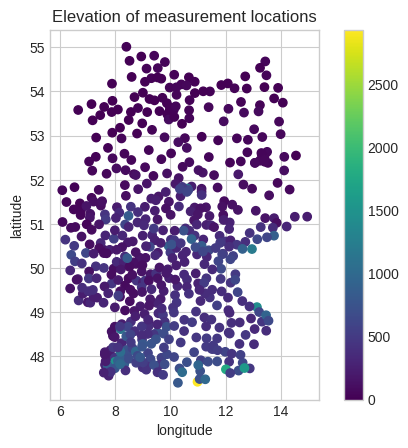

In [ ]:
gdf = gdf.to_crs(epsg=4326)

fig, ax = plt.subplots()
gdf.plot(column="elevation", cmap="viridis", legend=True, ax=ax)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("Elevation of measurement locations")
pass

Almost perfect fit:

R-squared: 0.9995458486369045


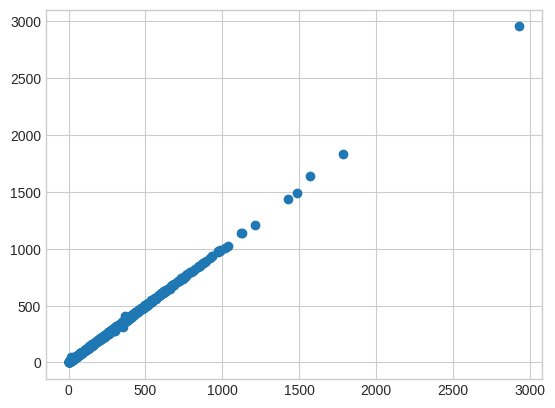

In [ ]:
fig, ax = plt.subplots()
ax.scatter(gdf.elevation, gdf.Stationshöhe)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(gdf.elevation, gdf.Stationshöhe)
print(f"R-squared: {r_value**2}")

In [ ]:
gdf_utm = gdf.to_crs(epsg=32632)
gdf_utm["x"] = gdf_utm.geometry.x
gdf_utm["y"] = gdf_utm.geometry.y

In [ ]:
df = df.merge(gdf_utm[["Stationskennung", "x", "y"]], on="Stationskennung")

In [ ]:
#df.drop(columns=["x_x", "y_x", "x_y", "y_y"], inplace=True)

In [ ]:
df

,Year,Month,Day,Tmean,Tmin,Tmax,Breite,Länge,Stationshöhe,Stationskennung,date,time,x,y
0,1992,1,1,6.2,2.9,7.8,52.934,8.237,44,1510,1992-01-01,-366,448717.149865,5.865201e+06
1,1992,1,2,7.1,6.8,7.8,52.934,8.237,44,1510,1992-01-02,-365,448717.149865,5.865201e+06
2,1992,1,3,5.1,4.1,7.3,52.934,8.237,44,1510,1992-01-03,-364,448717.149865,5.865201e+06
3,1992,1,4,6.1,4.5,8.0,52.934,8.237,44,1510,1992-01-04,-363,448717.149865,5.865201e+06
4,1992,1,5,4.3,3.8,5.6,52.934,8.237,44,1510,1992-01-05,-362,448717.149865,5.865201e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198114,1992,12,27,-3.4,-7.6,0.7,49.455,8.979,178,8970,1992-12-27,-5,498478.046955,5.478038e+06
198115,1992,12,28,-2.4,-3.9,0.7,49.455,8.979,178,8970,1992-12-28,-4,498478.046955,5.478038e+06
198116,1992,12,29,-4.8,-8.0,0.9,49.455,8.979,178,8970,1992-12-29,-3,498478.046955,5.478038e+06
198117,1992,12,30,-4.7,-9.3,2.7,49.455,8.979,178,8970,1992-12-30,-2,498478.046955,5.478038e+06


(266037.1665589863, 946912.1279851123, 5207930.238979294, 6138470.590843067)

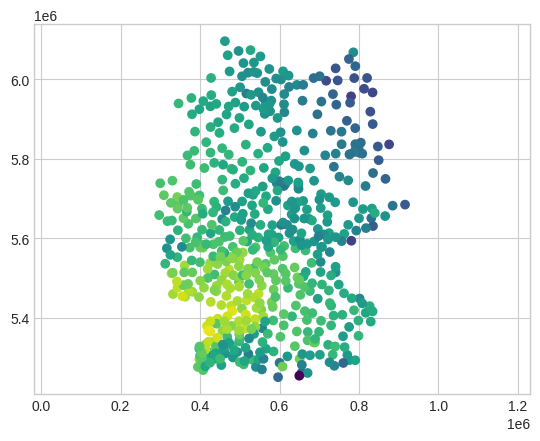

In [ ]:
plt.scatter(df.loc[df.time == -10].x, df.loc[df.time == -10].y, c=df.loc[df.time == -10].Tmin, cmap="viridis")
plt.axis('equal')

Then we create a `stif.Data` object for preprocessing:

In [ ]:
def create_data(day=None, days_before = 367):
    if day is None:
        data_df = df
    else:
        data_df = df.loc[(df.time <= day) & (df.time >= (day-days_before))]
    return Data(
        data_df,
        space_cols=["x", "y"],
        time_col="time",
        predictand_col="Tmax",
        covariate_cols=["y", "Stationshöhe"],
        #covariate_transformations={
        #    "time": lambda x: stif.sinusoidal_feature_transform(
        #        x,
        #        n_freqs=2,
        #        full_circle=365,
        #    ),
        #},
)

data = create_data()

To handle external drift (linear relationship to elevation and latitude), we perform a linear regression and do the geostatistics only on the residuals of this regression ("regression Kriging").

In [ ]:
covariate_model = LinearRegression()
predictor = Predictor(data, covariate_model)

To evaluate the covariate model, we perform a time series cross validation and plot the results.

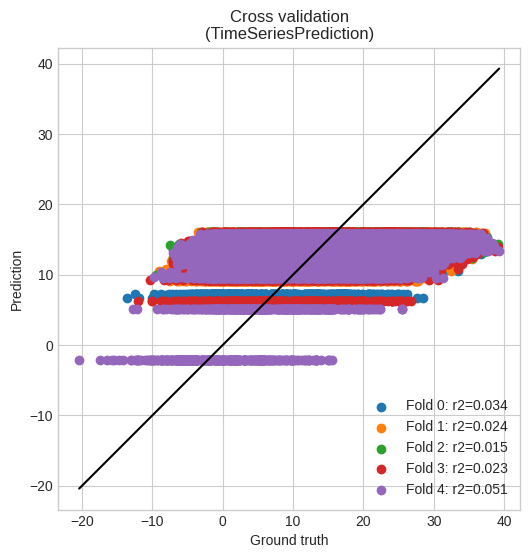

Explained variance:  [0.03372974541602625, 0.023611638714715943, 0.015523810930461734, 0.023007005797568758, 0.050770573903795246]


In [ ]:
predictor.calc_cross_validation()
predictor.plot_cross_validation_residuals()
score = predictor.get_cross_val_metric(
    sklearn.metrics.explained_variance_score,
)
print("Explained variance: ", score)

Not surprisingly, the prediction only based on a linear relationship to elevation and latitude is not sufficient (slightly better than nothing though).

Now, we can calculate an empirical variogram to analyze the spatio-temporal distribution and use it for space-time Kriging later.

In [ ]:
predictor.fit_covariate_model()
predictor._prepare_geostatistics()

In [ ]:
variogram_params = {
    "space_dist_max": 5e5,
    "time_dist_max": 3,
    "n_space_bins": 15,
    "n_time_bins": 3,
    "el_max": 4e8
}

predictor.calc_empirical_variogram(**variogram_params)

Let's have a look at the space-time varigoram.

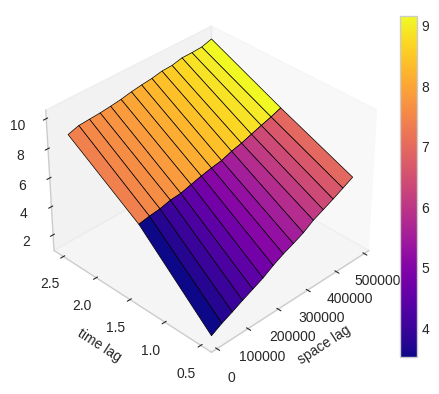

In [ ]:
predictor.plot_empirical_variogram()

As we can see, there is significant autocorrelation.

Now lets fit a model to the empirical variogram:

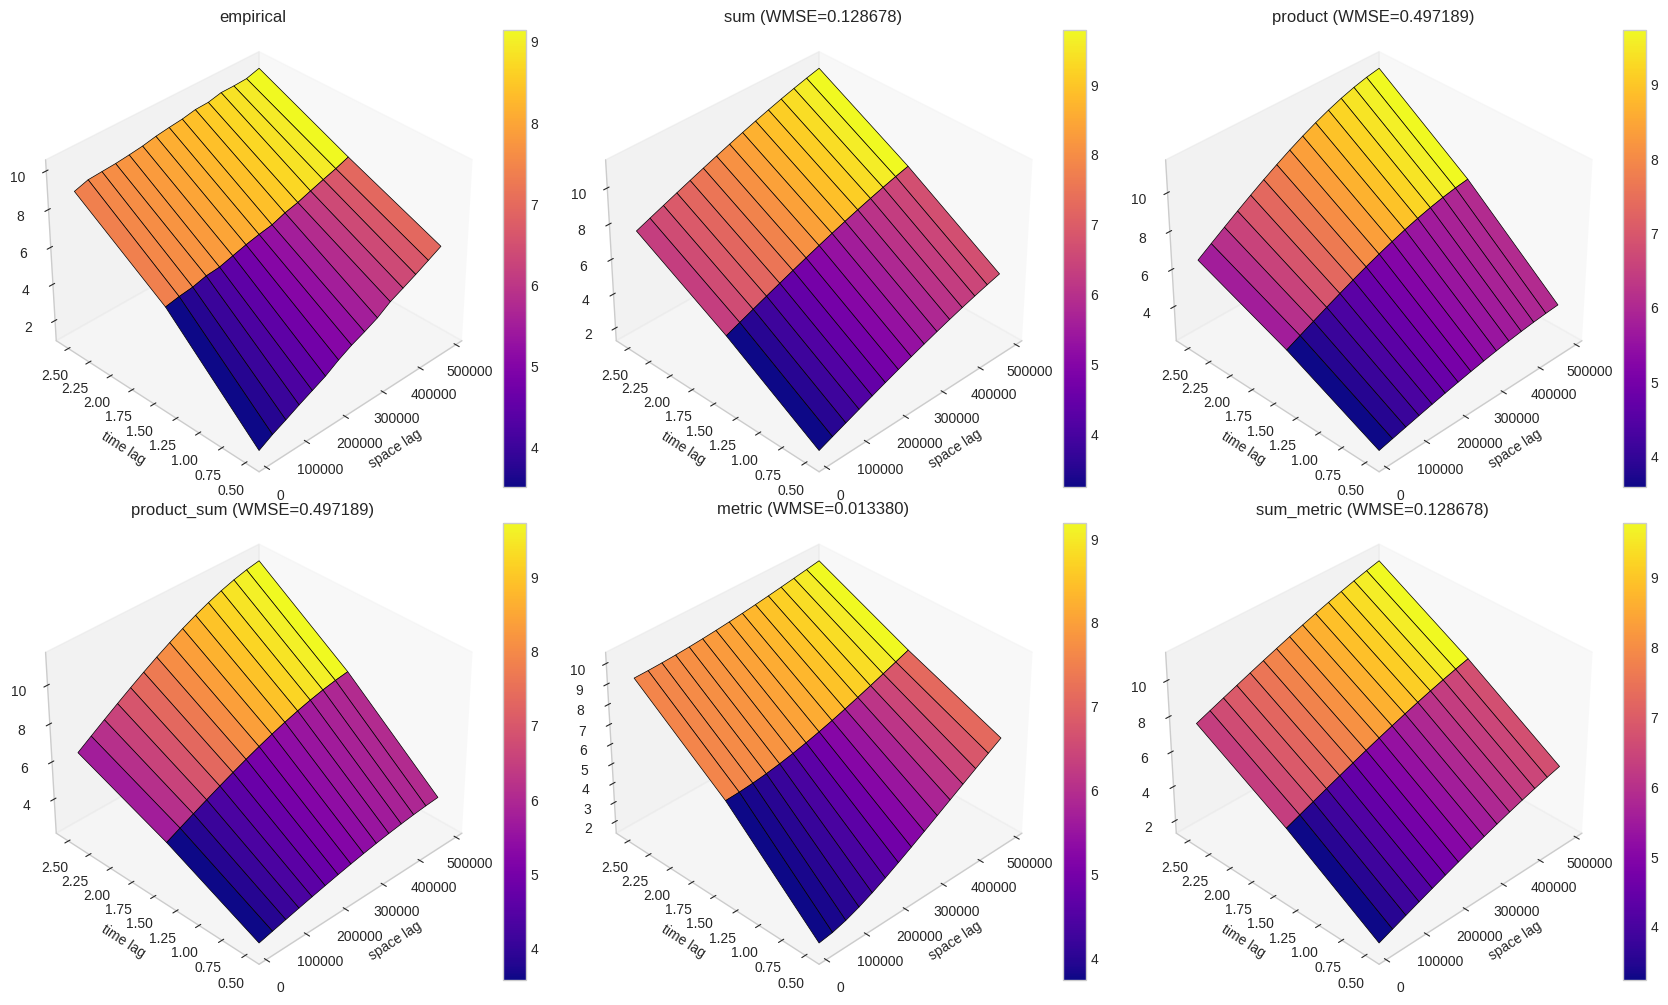

In [ ]:
predictor.plot_variogram_model_comparison()

As we can see, the `sum_metric` model performs best. Let's see, how Kriging performs using this variogram model. To evaluate that, we again use timeseries cross-validation to predict into the future, but this time we do not only the covariate regression, but also Kriging:

In [ ]:
predictor.save_empirical_variogram("/content/empirical_variogram_tmax.npz")
predictor_day = Predictor(create_data(-100, 30), covariate_model, cv_splits=10)
predictor_day.fit_covariate_model()
predictor_day._prepare_geostatistics()
predictor_day.load_empirical_variogram("/content/empirical_variogram_tmax.npz")
predictor_day.fit_variogram_model(st_model='product_sum')

In [ ]:
predictor_day._variogram_model_function(0,0)

1.074306196532626

Fold 0
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 1
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 2
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 3
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 4
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 5
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 6
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 7
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 8
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


Fold 9
	 train: 15069 samples
	 test: 1675 samples


/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))
/usr/local/lib/python3.11/dist-packages/stif/predictor.py:917: RuntimeWarning: invalid value encountered in sqrt
  kriging_std = np.sqrt(np.sum(w * kriging_vectors, axis=1))


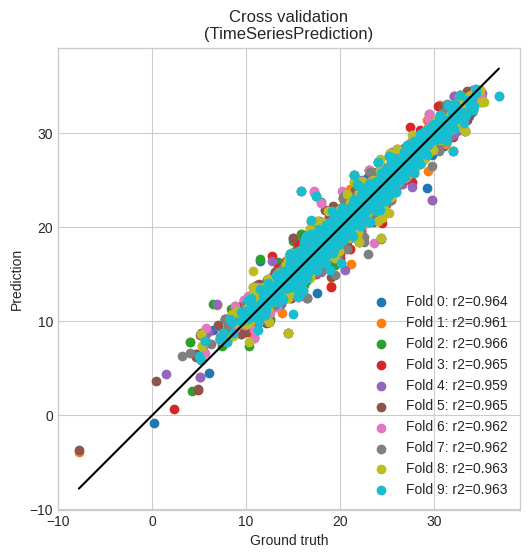

In [ ]:
kriging_params = {
    "min_kriging_points": 1,
    "max_kriging_points": 50,
    "space_dist_max": 1e5,
    "time_dist_max": 1
}

predictor_day.calc_cross_validation(
    kriging=True,
    geostat_params={
        "variogram_params": variogram_params,
        "kriging_params": kriging_params,
        "variogram_model_params": {
            "st_model": "sum_metric",
        },
    },
    empirical_variogram_path="/content/empirical_variogram_tmax.npz",
    verbose=True,
    cv_split=sklearn.model_selection.ShuffleSplit,
)
predictor_day.plot_cross_validation_residuals()


So this doesn't look too bad! The mean absolute error also looks decent:

In [ ]:
predictor_day.get_cross_val_metric(
    sklearn.metrics.mean_absolute_error)

[0.6069235780994564,
 0.6377949149247656,
 0.6235905724080313,
 0.6277133654835857,
 0.6442620409870888,
 0.6332526285764223,
 0.6184225088752652,
 0.6281789904548133,
 0.6269048203945671,
 0.6338631915263019]

## Load station locations

In [ ]:
apple_df_early = pd.read_csv("/content/drive/MyDrive/frost/frost_data/Apfel_Bluehdaten_fruehe_Reifezeit_utf8.csv", index_col=0)
apple_df_late = pd.read_csv("/content/drive/MyDrive/frost/frost_data/Apfel_Bluehdaten_spaete_Reifezeit_utf8.csv", index_col=0)

In [ ]:
apple_df_early["variety"] = "early"
apple_df_late["variety"] = "late"
apple_df = pd.concat([apple_df_early, apple_df_late])

In [ ]:
apple_locations = apple_df.groupby("Stations_id").agg({'geograph.Laenge': 'first', 'geograph.Breite': 'first', 'Stationshoehe': 'first'}).reset_index()

In [ ]:
apple_gdf = gpd.GeoDataFrame(apple_locations, geometry=gpd.points_from_xy(apple_locations['geograph.Laenge'], apple_locations['geograph.Breite']))

apple_gdf.rename(columns={"Stationshoehe":"Stationshöhe"}, inplace=True)

# Set EPSG to lan lon
apple_gdf.set_crs(epsg=4326, inplace=True)

apple_gdf

In [ ]:
apple_gdf = apple_gdf.to_crs(epsg=32632)
apple_gdf["x"] = apple_gdf.geometry.x
apple_gdf["y"] = apple_gdf.geometry.y

In [ ]:
apple_gdf.plot(column="Stationshöhe", cmap="viridis", legend=True)

In [ ]:
apple_gdf = apple_gdf[["Stations_id", "x", "y", "Stationshöhe", "geometry"]]

In [ ]:
apple_gdf

## Kriging

In [ ]:
import gc

In [ ]:
prediction_df_total = pd.DataFrame()
#prediction_df_total = pred_tmin

In [ ]:
(pd.to_datetime('2002-12-31') - start_day).days

In [ ]:
df.time.min()

In [ ]:
n_days = 30

for end_day in tqdm.tqdm(range(df.time.min()+n_days, df.time.max()+n_days, n_days)):
    gc.collect()
    predictor_day = Predictor(create_data(end_day, n_days), covariate_model, cv_splits=2)
    if len(predictor_day._data._training_df) < 100:
        print("Skipping, because not enough data")
        continue
    predictor_day.fit_covariate_model()
    predictor_day._prepare_geostatistics()
    predictor_day.load_empirical_variogram("/content/empirical_variogram_tmax.npz")
    predictor_day.fit_variogram_model(st_model='product_sum')

    prediction_df = pd.DataFrame()
    for i in range(end_day-n_days, end_day):
        prediction_df_day = apple_gdf.copy()
        prediction_df_day["time"] = i
        prediction_df = pd.concat([prediction_df, prediction_df_day])

    res_mean, res_std = predictor_day.predict(prediction_df, kriging_params)
    prediction_df["prediction_mean"] = res_mean
    prediction_df["prediction_std"] = res_std
    prediction_df_total = pd.concat([prediction_df_total, prediction_df.drop(columns=["geometry", "x", "y", "Stationshöhe"])])
    prediction_df_total.to_feather("/content/drive/MyDrive/frost/prediction_t_max.feather")

In [ ]:
prediction_df_total

In [ ]:
prediction_df_total_plot = gpd.GeoDataFrame(pd.merge(prediction_df_total, apple_gdf, on=["Stations_id"], how="left"))

In [ ]:
a = -238
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
prediction_df_total_plot.loc[prediction_df_total_plot.time == a].plot(ax=axs[0], column="prediction_mean", cmap="viridis", legend=True, markersize=16, marker="o")
prediction_df_total_plot.loc[prediction_df_total_plot.time == a].plot(ax=axs[1], column="prediction_std", cmap="magma", legend=True, markersize=16, marker="o")

## Post-process kriged values

In [ ]:
pred_tmin = pd.read_feather("/content/drive/MyDrive/frost/prediction_t_min3.feather")
pred_tmax = pd.read_feather("/content/drive/MyDrive/frost/prediction_t_max3.feather")

In [ ]:
df.time.max()

In [ ]:
pred_tmin.time.max()

In [ ]:
pred_tmax.time.max()

In [ ]:
pred_tmin

In [ ]:
pred_tmax

In [ ]:
pred_tmin.rename(columns={"prediction_mean": "t_min_mean", "prediction_std": "t_min_std"}, inplace=True)
pred_tmax.rename(columns={"prediction_mean": "t_max_mean", "prediction_std": "t_max_std"}, inplace=True)

In [ ]:
pred = pred_tmin.merge(pred_tmax, on=["Stations_id", "time"])

In [ ]:
pred = pred.sort_values(by=["Stations_id", "time"])

In [ ]:
pred["date"] = pd.to_datetime(pred.time, unit="D", origin=start_day)

In [ ]:
pred = pred.loc[(pred["t_max_std"] > 0) & (pred["t_min_std"] > 0)]

In [ ]:
pred["Referenzjahr"] = pred.date.dt.year
pred["Jultag"] = pred.date.dt.dayofyear

In [ ]:
pred

In [ ]:
all_dates = set(pd.date_range("1992-01-01", "2022-12-31"))
existing_dates = set(pred.date)
missing_dates = all_dates - existing_dates

In [ ]:
sorted(list(missing_dates))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist((pred.t_max_mean - pred.t_min_mean), bins=30)
axs[1].hist((df.Tmax - df.Tmin), bins=30)

pass

In [ ]:
pred.reset_index().drop(columns=["index", "time"])

In [ ]:
pred.reset_index().drop(columns=["index", "time"]).to_feather("/content/drive/MyDrive/frost/prediction_t_min_max_1992-2022.feather")

# Map for testing

Finally let's predict the temperature values for a grid over Germany, on one particular exemplary day. First, calculate the empirical variogram and fit the variogram model using all available training data:

In [ ]:
#predictor.calc_empirical_variogram(**variogram_params)
predictor.fit_variogram_model(st_model='product_sum')

Now we create a grid, covering all of Germany.

In [ ]:
lat_min, lat_max = df.y.min(), df.y.max()
lon_min, lon_max = df.x.min(), df.x.max()
lat_step = 10000 # in m
lon_step = 10000 # in m


latitudes = np.arange(lat_min, lat_max + lat_step, lat_step)
longitudes = np.arange(lon_min, lon_max + lon_step, lon_step)
lat_grid, lon_grid = np.meshgrid(latitudes, longitudes)

Next, we create a GeoDataFrame from this grid and use an arbitrary date (1st of March) for this example.

In [ ]:
#target_day = pd.to_datetime('2015-03-01')

# Calculate the difference in days
date_int = -100#(target_day - start_day).days

prediction_df = pd.DataFrame(
    {"x": lon_grid.flatten(), "y": lat_grid.flatten(), "time": date_int})


prediction_gdf = gpd.GeoDataFrame(
    prediction_df,
    geometry=gpd.points_from_xy(prediction_df['x'], prediction_df['y'])
)

# Set the CRS for UTM zone 32N (EPSG:32632)
prediction_gdf.set_crs(epsg=32632, inplace=True)
pass

As we did with our training data, we add the elevation covariable to the prediction grid.

In [ ]:
with rasterio.open(tiff_path) as src:
    raster_crs = src.crs

    # Reproject the GeoDataFrame to match the raster's CRS
    prediction_gdf = prediction_gdf.to_crs(raster_crs)

    # Extract elevation values
    def get_elevation(x, y):
        row, col = src.index(x, y)
        return src.read(1)[row, col]

    # Apply the function to extract elevation data
    prediction_gdf['elevation'] = prediction_gdf.apply(lambda row: get_elevation(
        row.geometry.x, row.geometry.y), axis=1)

Let's have a look at our prediction locations and their elevation:

In [ ]:
prediction_gdf = prediction_gdf.to_crs(epsg=4326)
prediction_gdf = prediction_gdf.loc[prediction_gdf.elevation > 0]
fig, ax = plt.subplots()
prediction_gdf.plot(column="elevation", cmap="viridis", legend=True, ax=ax, markersize=6, marker="s")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("Elevation of prediction locations")
pass

And now, last but not least, we perform space-time kriging on these prediction locations. It is acutally quite simple:

In [ ]:
prediction_gdf["Stationshöhe"] = prediction_gdf["elevation"]

In [ ]:
res_mean, res_std = predictor_day.predict(prediction_gdf, kriging_params)

prediction_gdf["prediction_mean"] = res_mean
prediction_gdf["prediction_std"] = res_std

Let's visualize the results:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
prediction_gdf.plot(column="prediction_mean", cmap="viridis", legend=True, ax=ax, markersize=9, marker="s")
ax.set_title("Prediction mean")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

ax = axs[1]
prediction_gdf.plot(column="prediction_std", cmap="magma", legend=True, ax=ax, markersize=9, marker="s")
ax.set_title("Prediction standard deviation")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
fig.tight_layout()
pass